In [1]:
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import redis
import numpy as np
import redisConfig

from GA_keras import GA, ga_main
from SourceLocalisation import SourceLocaliser
from SourceLocalisation_F import SourceLocaliser_F

# start redis server and config the maximum memory available
redisConfig.run()

Using TensorFlow backend.


Configured


In [40]:
# model = keras.models.load_model('alexnet-cifar10_origin.h5')
# new_output = keras.layers.Softmax()(keras.layers.Dense(10)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

model = keras.applications.ResNet50()
new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
new_model = keras.models.Model(input=model.input, output=new_output)
new_model.layers[-2].set_weights(model.layers[-1].get_weights())
model = new_model

# model = keras.applications.MobileNetV2()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

# model = keras.applications.VGG16()
# new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model

/data/yylaiai/anaconda3/envs/audee_test/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  if __name__ == '__main__':


In [6]:
# load inputs
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# expand cifar10 images from 32x32 to 224x224
x_test_224 = np.array([cv2.resize(i, (224, 224)) for i in x_test])
print(x_test_224.shape)

(10000, 224, 224, 3)


In [43]:
mut_level = 'i+w'
model = model
x = x_test_224[0]/255
input_scale = 255 # image scale
init_noise = 0 # scale of Cauchy noise added in initialization
r1 = 0.5 # crossover rate
r2 = 0.3 # mutation rate
r3 = 10 # mutation scale (larger scale can trigger NaN inconsistency easier, smaller scale can increase layer distance easier)
m = 3 # top m chromosomes selected
n = 6 # population size
layer_idx = -2 # index of layer used in calculation of fitness values
db_flag = 2
maxIter = 10
dynamicWeightMutDecay = np.inf

r = redis.Redis(db=db_flag)
r.flushdb()

fit = ['inc', ['tensorflow', 'theano']]

In [41]:
ga = GA(fit, mut_level, model, x, input_scale, db_flag)
ga.initPopulation(init_noise, n)
ga.initDynamicWeightMutation(r3)

[[3072, 3072, 10],
 [3072, 3072, 10],
 [3072, 12544, 10],
 [12544, 12800, 10],
 [12800, 12800, 10],
 [12800, 12800, 10],
 [12800, 12800, 10],
 [12800, 16960, 10],
 [16960, 17216, 10],
 [17216, 17216, 10],
 [17216, 54144, 10],
 [54144, 54400, 10],
 [54400, 54400, 10],
 [54400, 71040, 10],
 [71040, 87680, 10],
 [87680, 88704, 10],
 [88704, 89728, 10],
 [89728, 89728, 10],
 [89728, 89728, 10],
 [89728, 106176, 10],
 [106176, 106432, 10],
 [106432, 106432, 10],
 [106432, 143360, 10],
 [143360, 143616, 10],
 [143616, 143616, 10],
 [143616, 160256, 10],
 [160256, 161280, 10],
 [161280, 161280, 10],
 [161280, 161280, 10],
 [161280, 177728, 10],
 [177728, 177984, 10],
 [177984, 177984, 10],
 [177984, 214912, 10],
 [214912, 215168, 10],
 [215168, 215168, 10],
 [215168, 231808, 10],
 [231808, 232832, 10],
 [232832, 232832, 10],
 [232832, 232832, 10],
 [232832, 265728, 10],
 [265728, 266240, 10],
 [266240, 266240, 10],
 [266240, 413824, 10],
 [413824, 414336, 10],
 [414336, 414336, 10],
 [414336,

In [42]:
ga = ga_main(fit, mut_level, model, x, input_scale, init_noise, r1, r2, r3, m, n, layer_idx, db_flag, 10, dynamicWeightMutDecay, ga)

Continuing from the previous populations...

Running at iteration 1:
Average fitness value: 0.06594633435209593
Time taken: 150.34705233573914

Running at iteration 2:
Average fitness value: 0.06594633435209593
Time taken: 126.11771774291992

Running at iteration 3:


KeyboardInterrupt: 

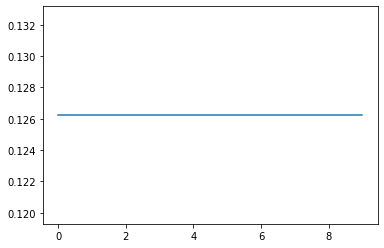

In [35]:
plt.plot(np.max(np.nan_to_num(ga.fit_hist, -1), axis=1))

In [28]:
ga.F[-1]

[[['nan', 'tensorflow', [11, 12, 13, 14, 15, 16, 17, 18]],
  ['nan', 'theano', [11, 12, 13, 14, 15, 16, 17, 18]]],
 array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -3.41296792e-02, -2.87883347e+01, -1.82542689e-02])]

In [37]:
def export_model(model, model_name, x, db_flag):
    w = model.get_weights()
    r = redis.Redis(db=db_flag)
    r.hset(model_name, 'weights', pickle.dumps(w))
    r.hset(model_name, 'input', pickle.dumps(x))

In [38]:
export_model(model, 'alexnet', x, 4)

## Inconsistency Localisation

In [29]:
SL = SourceLocaliser_F(ga, 'alexnet', 1)

In [30]:
L, UF = SL.localiseNan()

In [24]:
def formatP(ga, idx):
    formatted_c = ga.formatPopulations(ga.P)[idx]
    if ga.mut_level == 'i':
        x = formatted_c
    elif ga.mut_level == 'w':
        x = ga.input
        ga.model.set_weights(formatted_c)
    elif ga.mut_level == 'i+w':
        x = formatted_c[0]
        ga.model.set_weights(formatted_c[1])

    return x, ga.model

In [25]:
x, m = formatP(ga, 2)

In [10]:
import importlib
import SourceLocalisation

importlib.reload(SourceLocalisation)
from SourceLocalisation import SourceLocaliser

In [11]:
SL = SourceLocaliser(m, ['tensorflow', 'theano'], x, [], 1)
SL.prepare()

In [12]:
layers_dist = SL.compute_all_layers_dist()

In [13]:
print('Distance of layer between TF and TH:\n')
for i in range(len(model.layers)):
    print('{:<5} {:<30} {}'.format(i, model.layers[i].__class__.__name__, layers_dist[i]))

Distance of layer between TF and TH:

0     InputLayer                     0.0
1     ZeroPadding2D                  0.0
2     Conv2D                         9.250993803199927e-10
3     BatchNormalization             1.164115661010458e-09
4     ReLU                           1.2523957816390938e-08
5     DepthwiseConv2D                3.4123507466389054e-09
6     BatchNormalization             5.4550591998196646e-08
7     ReLU                           1.6805962118547654e-08
8     Conv2D                         4.55952779387245e-09
9     BatchNormalization             2.7016953101003902e-08
10    Conv2D                         2.3405880952219487e-09
11    BatchNormalization             4.1265296630979493e-08
12    ReLU                           3.7347351225230805e-08
13    ZeroPadding2D                  3.6689261004722e-08
14    DepthwiseConv2D                9.04596113812869e-10
15    BatchNormalization             3.1190484692377228e-09
16    ReLU                           5.4169040409

In [14]:
print('Change rate between layers:\n')
for i in range(1,len(model.layers)):
    print('{:<5} {:<30} {}'.format(i, model.layers[i].__class__.__name__, SL.compute_dists_change(i)))

Change rate between layers:

1     ZeroPadding2D                  0.0
2     Conv2D                         0.009250993803199927
3     BatchNormalization             0.0023682541028745576
4     ReLU                           0.11229122185425937
5     DepthwiseConv2D                -0.08097481857703356
6     BatchNormalization             0.37349054367943546
7     ReLU                           -0.24422183953905147
8     Conv2D                         -0.3234608393147243
9     BatchNormalization             -0.17815291770292294
10    Conv2D                         -0.3378182071511179
11    BatchNormalization             -0.08596081836666256
12    ReLU                           -0.11131138710336727
13    ZeroPadding2D                  -0.1155694763930963
14    DepthwiseConv2D                -0.3471096111039791
15    BatchNormalization             -0.33278127805268487
16    ReLU                           -0.002468781151705726
17    Conv2D                         -0.21774988432568068
18    

In [18]:
for i in range(len(layers_r3)):
    if layers_r3[i][2] == 0:
        print(model.layers[i])

In [19]:
p1 = SL.predictions_1

In [20]:
p2 = SL.predictions_2

In [59]:
saveInconsistencyCases(m, x)

In [58]:
def saveInconsistencyCases(model, x, saved_inc_dir = "saved_inc"):
    if not os.path.exists(saved_inc_dir):
        os.mkdir(saved_inc_dir)
        
    model_save_path = os.path.join(saved_inc_dir, "weight")
    input_save_path = os.path.join(saved_inc_dir, "input.npy")
    model.save_weights(model_save_path)
    np.save(input_save_path, x)

In [7]:
def loadInconsistencyCases(model, saved_inc_dir = "saved_inc"):
    model_path = os.path.join(saved_inc_dir, "weight")
    input_path = os.path.join(saved_inc_dir, "input.npy")
    model.load_weights(model_path)
    x = np.load(input_path)
    
    return model, x

In [9]:
m, x = loadInconsistencyCases(model)

In [94]:
np.where(p1[141]!=p2[141])

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 6, 6, 6]),
 array([0, 0, 0, ..., 6, 6, 6]),
 array([  0,   1,   2, ..., 157, 158, 159]))

In [95]:
p1[141]

array([[[[ -11371.323  ,    9833.836  ,   -5115.335  , ...,
             2414.1025 ,  -11182.602  ,   -1433.7375 ],
         [  -5370.568  , -120225.35   ,   -1490.2131 , ...,
          -149239.45   ,  -12002.011  ,    2297.613  ],
         [  -4054.2673 , -127895.82   ,   -1665.9005 , ...,
             4220.38   ,  -13927.469  ,   -1054.0033 ],
         ...,
         [  -7417.424  ,    -742.14185,   -2631.4143 , ...,
             5738.8877 ,  -12798.846  ,     501.57092],
         [  -6897.5605 ,    3991.1748 ,   -3266.96   , ...,
           -23191.027  ,  -13324.172  ,   -1186.6132 ],
         [  -6904.646  , -118888.24   ,   -1719.7078 , ...,
             3161.0645 ,  -12469.955  ,    4648.1494 ]],

        [[   4346.5156 ,    8846.314  ,   -3683.1262 , ...,
             5349.3486 ,  -12792.327  ,   -3516.9033 ],
         [  -4987.2104 , -117524.36   ,   -8329.361  , ...,
          -155596.67   ,  -11046.47   ,    1198.6836 ],
         [   -603.26013, -116915.53   ,   -6415.3354 , .

In [96]:
p2[141]

array([[[[-1.13713193e+04,  9.83383496e+03, -5.11533301e+03, ...,
           2.41410254e+03, -1.11826016e+04, -1.43373779e+03],
         [-5.37058154e+03, -1.20228125e+05, -1.49020435e+03, ...,
          -1.49239484e+05, -1.20035791e+04,  2.29988037e+03],
         [-4.06205688e+03, -1.27882125e+05, -1.60917993e+03, ...,
           5.03096436e+03, -1.39189570e+04, -9.30318848e+02],
         ...,
         [-7.11859619e+03, -2.64686157e+02, -2.74989282e+03, ...,
           5.76804199e+03, -1.48445205e+04,  3.88336914e+02],
         [-7.07224268e+03,  4.02273901e+03, -3.36344556e+03, ...,
          -2.31691992e+04, -1.32283545e+04, -1.12508789e+03],
         [-5.32213428e+03, -1.18929438e+05, -1.74879211e+03, ...,
           3.15390381e+03, -1.25736602e+04,  4.52434375e+03]],

        [[ 4.34651562e+03,  8.84631641e+03, -3.68312573e+03, ...,
           5.34934814e+03, -1.27923301e+04, -3.51690356e+03],
         [-5.02579932e+03, -1.17562195e+05, -8.30824609e+03, ...,
          -1.55517438e

In [93]:
p1[38][0][19][20][97]

-1203.6234

In [21]:
p1[-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [25]:
p2[-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [27]:
np.where(p2[-1]!=p1[-1])

(array([0, 0]), array([200, 681]))

In [28]:
model.layers[-1]